In [ ]:
from langchain_community.vectorstores import Chroma

from langchain_core.output_parsers import StrOutputParser, JsonOutputParser, BaseOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

from langchain.prompts import PromptTemplate

from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_history_aware_retriever

from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain

from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

from langgraph.graph import StateGraph, END

from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from typing import Annotated, Sequence, TypedDict

import operator

import pandas as pd
import sqlalchemy as sql

import plotly as pl
import plotly.express as px
import plotly.io as pio

import os
import yaml
import ast
import json
import re

from pprint import pprint
from IPython.display import Image

In [ ]:
PATH_PRODUCTS_VECTORDB = "data/data-rag-product-information/products_clean.db"

PATH_TRANSACTIONS_DATABASE = "sqlite:///data/database-sql-transactions/leads_scored.db"

In [ ]:
os.environ["OPENAI_API_KEY"] = yaml.safe_load(open('../credentials.yml'))['openai']

OPENAI_LLM = ChatOpenAI(
    model = "gpt-4o-mini"
)

In [ ]:
subagent_names = ["Product_Expert", "Business_Intelligence_Expert", "Marketing_Email_Writer"]

def create_supervisor_agent(subagent_names: list, llm, temperature=0):

    system_prompt = (
        """
        You are a supervisor tasked with managing a conversation between the following workers:  {subagent_names}. 
        
        Each worker has the following knowledge and skills:
        1. Product_Expert: Can explain details of contents inside the courses from the course sales pages. Do not have the Product Expert write emails (the Marketing Expert shoudl do this). 
        2. Business_Intelligence_Expert: Has knowledge of the company's customer transactions database. Has access to the customer SQL database that includes SQL tables containing information on customers, lead scores (how likely they are to buy), transactions, courses purchased, and types of products. Can write SQL, produce data in table and charts. 
        3. Marketing_Email_Writer: Is skilled at drafting marketing emails using information from the Product_Expert to help explain what's inside various products that may be of benefit to the customer. Uses SQL queries and data from the Business_Intelligence_Expert to target customers by their email address and products that they have not currently purchased.
        
        Given the following user request, respond with the worker to act next. 
        
        Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.
        """
    )

    route_options = ["FINISH"] + subagent_names 

    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "route_schema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": route_options},
                    ],
                }
            },
            "required": ["next"],
        },
    }

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {route_options}",
            ),
        ]
    ).partial(route_options=str(route_options), subagent_names=", ".join(subagent_names))
    
    llm.temperature = temperature
    
    supervisor_chain = (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )
    
    return supervisor_chain
    

supervisor_agent = create_supervisor_agent(subagent_names=subagent_names, llm=OPENAI_LLM, temperature=0.7)

In [ ]:
def create_rag_question_preprocessor_agent(llm, temperature=0):
    
    llm.temperature = temperature
    
    prompt = PromptTemplate(
        template="""
        You are a question preparer for a Product Expert. Your goal is to extract the relevant part of the question so the Product Expert knows which product or products to provide information on. 
        
        Remove anything about writing marketing emails or emails in general. 
        
        Remove anything related to business analytics that requires knowledge of a customers, transactions, or subscribers. Leave only information related to collecting information on the product or products in question. 
        
        Only return the product or products to collect information on, and what information to collect on those products. 
        
        User Input: {user_question}
        """,
        input_variables=['user_question']
    )
    
    rag_preprocessor = prompt | llm | StrOutputParser()
    
    return rag_preprocessor


rag_preprocessor = create_rag_question_preprocessor_agent(llm=OPENAI_LLM, temperature=0)

In [ ]:
def create_rag_agent(db_path, llm, temperature = 0):
    
    embedding_function = OpenAIEmbeddings(
        model='text-embedding-ada-002',
    )
    
    llm.temperature = temperature
    
    vectorstore = Chroma(
        embedding_function=embedding_function, 
        persist_directory=db_path
    )

    retriever = vectorstore.as_retriever()
    
    contextualize_q_system_prompt = """Given a chat history and the latest user question \
    which might reference context in the chat history, formulate a standalone question \
    which can be understood without the chat history. Do NOT answer the question, \
    just reformulate it if needed and otherwise return it as is."""
    
    contextualize_q_prompt = ChatPromptTemplate.from_messages([
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ])
    
    history_aware_retriever = create_history_aware_retriever(llm, retriever, contextualize_q_prompt)
    
    qa_system_prompt = """You are an assistant for question-answering tasks. \
    Use the following pieces of retrieved context to answer the question. \
    If you don't know the answer, just say that you don't know. \

    {context}"""
    
    qa_prompt = ChatPromptTemplate.from_messages([
        ("system", qa_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}")
    ])
    
    question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)
    

    prompt = ChatPromptTemplate.from_template(
        """Answer the question based only on the following context:
        {context}

        Question: {question}
        """
    )
    
    rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)
    
    return rag_chain


product_expert_agent = create_rag_agent(PATH_PRODUCTS_VECTORDB, llm=OPENAI_LLM, temperature=0.7)

In [ ]:
def create_business_intelligence_agent(db_path, llm, temperature=0):    
    
    PATH_DB = db_path
    
    llm.temperature = temperature
    
    # * Routing Preprocessor Agent

    routing_preprocessor_prompt = PromptTemplate(
        template="""
        You are an expert in routing decisions for a SQL database agent, a Charting Visualization Agent, and a Pandas Table Agent. Your job is to:
        
        1. Determine what the correct format for a Users Question should be for use with a SQL translator agent 
        2. Determine whether or not a chart should be generated or a table should be returned based on the users question.
        
        Use the following criteria on how to route the the initial user question:
        
        From the incoming user question and the chat_history, remove any details about the format of the final response as either a Chart or Table and return only the important part of the incoming user question that is relevant for the SQL generator agent. This will be the 'formatted_user_question_sql_only'. If 'None' is found, return the original user question.
        
        Next, determine if the user would like a data visualization ('chart') or a 'table' returned with the results of the SQL query. If unknown, not specified or 'None' is found, then select 'table'.  
        
        Return JSON with 'formatted_user_question_sql_only' and 'routing_preprocessor_decision'.
        
        INITIAL_USER_QUESTION: {initial_question}
        CONTEXT: {chat_history}
        """,
        input_variables=["initial_question", "chat_history"]
    )

    routing_preprocessor = routing_preprocessor_prompt | llm | JsonOutputParser()

    # * SQL Agent

    db = SQLDatabase.from_uri(PATH_DB)

    def extract_sql_code(text):
        sql_code_match = re.search(r'```sql(.*?)```', text, re.DOTALL)
        if sql_code_match:
            sql_code = sql_code_match.group(1).strip()
            return sql_code
        else:
            sql_code_match = re.search(r"sql(.*?)'", text, re.DOTALL)
            if sql_code_match:
                sql_code = sql_code_match.group(1).strip()
                return sql_code
            else:
                return None
        
    class SQLOutputParser(BaseOutputParser):
        def parse(self, text: str):
            sql_code = extract_sql_code(text)
            if sql_code is not None:
                return sql_code
            else:
                # Assume ```sql wasn't used
                return text

    prompt_sqlite = PromptTemplate(
        input_variables=['input', 'table_info', 'top_k'],
        template="""
        You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
        
        Do not use a LIMIT clause with {top_k} unless a user specifies a limit to be returned.
        
        Return SQL in ```sql ``` format.
        
        Only return a single query if possible.
        
        Never query for all columns from a table unless the user specifies it. You must query only the columns that are needed to answer the question unless the user specifies it. Wrap each column name in double quotes (") to denote them as delimited identifiers.
        
        Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
        
        Pay attention to use date(\'now\') function to get the current date, if the question involves "today".
            
        Only use the following tables:
        {table_info}
        
        Question: {input}'
        """
    )

    sql_generator = (
        create_sql_query_chain(
            llm = llm,
            db = db,
            k = int(1e7),
            prompt = prompt_sqlite
        ) 
        | SQLOutputParser() # NEW SQLCodeExtactor
    )

    # * Dataframe Conversion
        
    sql_engine = sql.create_engine(PATH_DB)

    conn = sql_engine.connect()

    # * Chart Instructor

    prompt_chart_instructions = PromptTemplate(
        template="""
        You are a supervisor that is an expert in providing instructions to a chart generator agent for plotting. 
        
        You will take a question that a user has and the data that was generated to answer the question, and create instructions to create a chart from the data that will be passed to a chart generator agent.
        
        USER QUESTION: {question}
        
        DATA: {data}
        
        Formulate "chart generator instructions" by informing the chart generator of what type of plotly plot to use (e.g. bar, line, scatter, etc) to best represent the data. 
        
        Come up with an informative title from the user's question and data provided. Also provide X and Y axis titles.
        
        Return your instructions in the following format:
        CHART GENERATOR INSTRUCTIONS: FILL IN THE INSTRUCTIONS HERE
        
        """,
        input_variables=['question', 'data']
    )

    chart_instructor = prompt_chart_instructions | llm | StrOutputParser()


    # * Chart Generator

    repl = PythonREPL()

    @tool
    def python_repl(
        code: Annotated[str, "The python code to execute to generate your chart."]
    ):
        """Use this to execute python code. If you want to see the output of a value,
        you should print it out with `print(...)`. This is visible to the user."""
        try:
            result = repl.run(code)
        except BaseException as e:
            return f"Failed to execute. Error: {repr(e)}"
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"


    prompt_chart_generator = PromptTemplate(
        template = """
        You are an expert in creating data visualizations and plots using the plotly python library. You must use plotly or plotly.express to produce plots.
        
        Your job is to produce python code to generate visualizations.
        
        Create the python code to produce the requested visualization given the plot requested from the original user question and the input data. 
        
        The input data will be provided as a dictionary and will need converted to a pandas data frame before creating the visualization. 
        
        The output of the plotly chart should be stored as a JSON object with pio.to_json() and then to a dictionary. 
        
        Make sure to add: import plotly.io as pio
        Make sure to print the fig_dict
        Make sure to import json
        
        Here's an example of converting a plotly object to JSON:
        
        import json
        import plotly.graph_objects as go
        import plotly.io as pio

        # Create a sample Plotly figure
        fig = go.Figure(data=go.Bar(y=[2, 3, 1]))

        # Convert the figure to JSON
        fig_json = pio.to_json(fig)
        fig_dict = json.loads(fig_json)
        
        print(fig_dict) # MAKE SURE TO DO THIS
        
        
        CHART INSTRUCTIONS: {chart_instructions}
        INPUT DATA: {data}
        
        Important Notes on creating the chart code:
        - Do not use color_discrete_map. This is an invalid property.
        - If bar plot, do not add barnorm='percent' unless user asks for it
        - If bar plot, do not add a trendline. Plotly bar charts do not natively support the trendline.  
        - For line plots, the line width should be updated on traces (example: # Update traces
    fig.update_traces(line=dict(color='#3381ff', width=0.65)))
        - For Bar plots, the default line width is acceptable
        - Super important - Make sure to print(fig_dict)
        """,
        input_variables=["chart_instructions", "data"]
    )

    tools = [python_repl]

    chart_generator = prompt_chart_generator.partial(tool_names=", ".join([tool.name for tool in tools])) | llm.bind_tools(tools)
    
    # * Summarizer
    
    summarizer_prompt = PromptTemplate(
        template="""
        You are an expert in summarizing the analysis results of a Customer Transactions Expert. Your goal is to help the business understand the analysis in basic terms that business people can easily understand. Be consice in your explanation of the results. 
        
        The Customer Transactions Expert as knowledge of the company's customer transactions database. Has analytics and business intelligence skills. Can write SQL, produce data in table and charts. Has access to the customer SQL database that includes SQL tables containing information on customers, lead scores (how likely they are to buy), transactions, courses purchased, and types of products.
        
        You are given the results of a the Customer Transaction Expert's analysis that contain:
        
        - user_question: The initial user question that was asked to the Customer Transactions Expert
        - chat_history: The previous chat history provided for additional context on the user's question
        - formatted_user_question_sql_only: A processed version of the user question provided to the SQL expert
        - sql_query: The sql query that the SQL expert created by accessing the Customer Analytics Database
        - data: The results of the sql query when run on the database
        - routing_processor_decision: either 'table' or 'chart'. If table, a chart is not returned. If chart, plotly code is created. 
        
        If a 'chart' was determined, the application will attempt to produce a chart. Sometimes errors occur, which is denoted by: 'chart_plotly_error'
        
        If a chart was successful, Python code and JSON will be produced, which are contained in 'chart_plotly_code' and 'chart_plotly_json' respectively. 
         
        ANALYSIS RESULTS FOR SUMMARIZATION: {results}
        """,
        input_variables=["results"]
    )

    summarizer = summarizer_prompt | llm | StrOutputParser()


    # * LANGGRAPH
    class GraphState(TypedDict):
        """
        Represents the state of our graph.
        """
        user_question: str
        chat_history: list
        formatted_user_question_sql_only: str
        sql_query : str
        data: dict
        routing_preprocessor_decision: str
        chart_generator_instructions: str
        chart_plotly_code: str
        chart_plotly_json: dict
        chart_plotly_error: bool
        summary: str
        num_steps : int
        
    def preprocess_routing(state):
        print("---ROUTER---")
        question = state.get("user_question")
        
        chat_history = state.get("chat_history")
        
        num_steps = state.get("num_steps")
        
        num_steps += 1
        
        # Chart Routing and SQL Prep
        response = routing_preprocessor.invoke({"initial_question": question, "chat_history": chat_history})
        
        formatted_user_question_sql_only = response['formatted_user_question_sql_only']
        
        routing_preprocessor_decision = response['routing_preprocessor_decision']
        
        return {
            "formatted_user_question_sql_only": formatted_user_question_sql_only,
            "routing_preprocessor_decision": routing_preprocessor_decision,
            "num_steps": num_steps
        }

    def generate_sql(state):
        print("---GENERATE SQL---")
        question = state.get("formatted_user_question_sql_only")
        
        # Handle case when formatted_user_question_sql_only is None:
        if question is None:
            question = state.get("user_question")
        
        num_steps = state.get("num_steps")
        
        num_steps += 1
        
        # Generate SQL
        sql_query = sql_generator.invoke({"question": question})
        
        return {"sql_query": sql_query, "num_steps": num_steps}


    def convert_dataframe(state):
        print("---CONVERT DATA FRAME---")

        sql_query = state.get("sql_query")
        
        num_steps = state.get("num_steps")
        
        num_steps += 1
        
        # Remove trailing ' that gpt-3.5-turbo sometimes leaves
        sql_query = sql_query.rstrip("'")
        
        df = pd.read_sql(sql_query, conn)
        
        return {"data": dict(df), "num_steps": num_steps}


    def decide_chart_or_table(state):
        print("---DECIDE CHART OR TABLE---")
        return "chart" if state.get('routing_preprocessor_decision') == "chart" else "table"

    def instruct_chart_generator(state):
        print("---INSTRUCT CHART GENERATOR---")
        
        question = state.get("user_question")
        
        data = state.get("data")
        
        num_steps = state.get("num_steps")
        
        num_steps += 1
        
        chart_generator_instructions = chart_instructor.invoke({"question": question, "data": data})
        
        return {"chart_generator_instructions": chart_generator_instructions, "num_steps": num_steps}


    def generate_chart(state):
        print("---GENERATE CHART---")
        
        chart_instructions = state.get("chart_generator_instructions")
        
        data = state.get("data")
        
        num_steps = state.get("num_steps")
        
        num_steps += 1
        
        response = chart_generator.invoke({"chart_instructions": chart_instructions, "data": data})
        
        # Fix - if invalid tool calls
        try:
            code = dict(response)['tool_calls'][0]['args']['code']
        except: 
            code = dict(response)['invalid_tool_calls'][0]['args']
        
        result = repl.run(code)
        
        chart_plotly_error = False
        if "error" in result[:40].lower():
            chart_plotly_error = True
        else:
            try:
                result_dict = ast.literal_eval(result)
            
                fig = pio.from_json(json.dumps(result_dict))
            except:
                chart_plotly_error = True
            
        return {
            "chart_plotly_code": code, 
            "chart_plotly_json": result, 
            "chart_plotly_error": chart_plotly_error,
            "num_steps": num_steps,
        }
        
    def summarize_results(state):
        print("---SUMMARIZE RESULTS----")
        
        result = summarizer.invoke({"results": dict(state)})
        
        num_steps = state.get("num_steps")
        
        num_steps += 1
        
        return {"summary": result, "num_steps": num_steps}
        
        
    def state_printer(state):
        """print the state"""
        print("---STATE PRINTER---")
        print(f"User Question: {state['user_question']}")
        print(f"Formatted Question (SQL): {state['formatted_user_question_sql_only']}")
        print(f"SQL Query: \n{state['sql_query']}\n")
        print(f"Data: \n{pd.DataFrame(state['data'])}\n")
        print(f"Chart or Table: {state['routing_preprocessor_decision']}")
        
        if state['routing_preprocessor_decision'] == "chart":
            print(f"Chart Code: \n{pprint(state['chart_plotly_code'])}")
            print(f"Chart Error: {state['chart_plotly_error']}")
        
        print(f"Num Steps: {state['num_steps']}")

    # * WORKFLOW DAG

    workflow = StateGraph(GraphState)

    workflow.add_node("preprocess_routing", preprocess_routing)
    workflow.add_node("generate_sql", generate_sql)
    workflow.add_node("convert_dataframe", convert_dataframe)
    workflow.add_node("instruct_chart_generator", instruct_chart_generator)
    workflow.add_node("generate_chart", generate_chart)
    workflow.add_node("summarizer", summarize_results)
    workflow.add_node("state_printer", state_printer)

    workflow.set_entry_point("preprocess_routing")
    workflow.add_edge("preprocess_routing", "generate_sql")
    workflow.add_edge("generate_sql", "convert_dataframe")

    workflow.add_conditional_edges(
        "convert_dataframe", 
        decide_chart_or_table,
        {
            # Result : Step Name To Go To
            "chart":"instruct_chart_generator", # Path Chart
            "table":"summarizer" # Summarizer
        }
    )

    workflow.add_edge("instruct_chart_generator", "generate_chart")
    workflow.add_edge("generate_chart", "summarizer")
    workflow.add_edge("summarizer", "state_printer")
    workflow.add_edge("state_printer", END)

    app = workflow.compile()
    
    return app

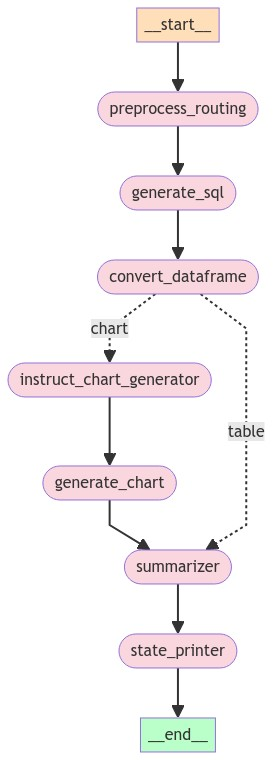

In [ ]:
business_intelligence_agent = create_business_intelligence_agent(db_path=PATH_TRANSACTIONS_DATABASE, llm = OPENAI_LLM, temperature=0)

Image(business_intelligence_agent.get_graph().draw_mermaid_png())

In [ ]:
def create_marketing_agent(llm, temperature = 1.0):
    
    llm.temperature = temperature
    
    # * Routing Preprocessor Agent

    marketing_agent_prompt = PromptTemplate(
        template="""
        You are an expert in writing marketing email copy for Business Science, a premium data science educational platform. 
        
        Your emails are designed to inform customers about products that they might be interested in, and to target customers by email address.
        
        Your email should specify:
        
        1. Which customer email addresses to target
        2. An attention grabbing email subject
        3. Include email content designed to educate and provide reasons that they should invest in our educational program
        
        Examples of good reasons to purchase include:
        1. Getting a career advancement or new job
        2. Developing a portfolio to attract recruiters and wow their bosses
        3. Taking action: Stop procrastinating and finally take action towards a fullfilling career
        4. Increased Salary: Many Data Scientists make over $100,000 per year. 
        
        IMPORTANT: Make sure to explain why the product you are recommending will help them address their goal.
        
        INITIAL_USER_QUESTION: {initial_question}
        CONTEXT: {chat_history}
        """,
        input_variables=["initial_question", "chat_history"]
    )

    marketing_agent = marketing_agent_prompt | llm | StrOutputParser()
    
    return marketing_agent

marketing_agent = create_marketing_agent(llm=OPENAI_LLM, temperature=1.2)

In [ ]:
class GraphState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    num_steps: Annotated[Sequence[int], operator.add]
    next: str
    
# Helper functions to get last question that the Human asked
def get_last_human_message(msgs):
    # Iterate through the list in reverse order
    for msg in reversed(msgs):
        if isinstance(msg, HumanMessage):
            return msg
    return None

def get_last_ai_message(msgs, target_name=None):
    for msg in reversed(msgs):
        if not target_name:
            if isinstance(msg, AIMessage):
                return msg
        if target_name:
            if isinstance(msg, AIMessage) and msg.name == target_name:
                return msg
    return None
    
def supervisor_node(state):
    
    print("---SUPERVISOR---")
    
    result = supervisor_agent.invoke(state)
    
    print(result)
    
    return {'next': result['next'], 'num_steps': 1}


def product_expert_node(state):
    
    print("---PRODUCT EXPERT---")
    
    # print(state["messages"])
    
    messages = state.get("messages")
    
    last_question = get_last_human_message(messages)
    if last_question:
        last_question = last_question.content
    
    # Implement a preprocessor
    last_question = rag_preprocessor.invoke({'user_question': last_question})
    
    result = product_expert_agent.invoke({"input": last_question, "chat_history": messages})
    
    # print(result)
    
    return {
        "messages": [AIMessage(content=result['answer'], name='Product_Expert')],
        'num_steps': 1
    }
    
def business_intelligence_expert_node(state):
    
    print("---BUSINESS INTELLIGENCE EXPERT---")
    
    messages = state.get("messages")
    num_steps = state.get("num_steps")
    
    last_question = get_last_human_message(messages)
    if last_question:
        last_question = last_question.content
    
    result = business_intelligence_agent.invoke({
        "user_question": last_question, 
        "chat_history": messages, 
        "num_steps": num_steps
    })
    
    return {
        "messages": [AIMessage(content=result['summary'], additional_kwargs=result, name='Business_Intelligence_Expert')],
        'num_steps': 1
    }


def email_writer_node(state):
    
    print("---MARKETING EMAIL WRITER---")
    
    messages = state.get("messages")
    num_steps = state.get("num_steps")
    
    last_question = get_last_human_message(messages)
    if last_question:
        last_question = last_question.content
        
    result = marketing_agent.invoke({'initial_question': last_question,'chat_history': messages})
    
    return {
        "messages": [AIMessage(content=result, name='Marketing_Email_Writer')],
        'num_steps': 1
    }

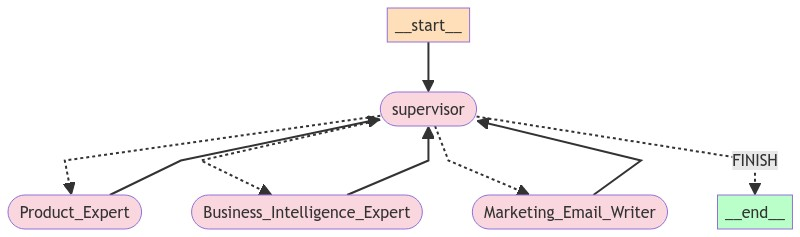

In [ ]:
workflow = StateGraph(GraphState)

workflow.add_node("supervisor", supervisor_node)
workflow.add_node("Product_Expert", product_expert_node)
workflow.add_node("Business_Intelligence_Expert", business_intelligence_expert_node)
workflow.add_node("Marketing_Email_Writer", email_writer_node)

for member in subagent_names:
    workflow.add_edge(member, "supervisor")

conditional_map = {
    'Product_Expert': 'Product_Expert', 
    'Business_Intelligence_Expert': 'Business_Intelligence_Expert', 
    'Marketing_Email_Writer':'Marketing_Email_Writer',
    'FINISH': END
}
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

workflow.set_entry_point("supervisor")

app = workflow.compile()

Image(app.get_graph().draw_mermaid_png())

In [ ]:
# Test Product Expert
result = app.invoke(
    input = {"messages": [HumanMessage(content="Is the 4-Course R-Track Open for Enrollment?")]},
    
    # * NEW: Add thread_id
    config = {"recursion_limit": 10},
)

result

---SUPERVISOR---
{'next': 'Product_Expert'}
---PRODUCT EXPERT---
---SUPERVISOR---
{'next': 'FINISH'}


{'messages': [HumanMessage(content='Is the 4-Course R-Track Open for Enrollment?'),
  AIMessage(content='The 4-Course R-Track is currently closed for enrollment.', name='Product_Expert')],
 'num_steps': 3,
 'next': 'FINISH'}

In [ ]:
result = app.invoke(
    input = {"messages": [HumanMessage(content="What tables are in the customer analytics database?")]},
    
    # * NEW: Add thread_id
    config = {"recursion_limit": 10},
)

result['messages']

---SUPERVISOR---
{'next': 'Business_Intelligence_Expert'}
---BUSINESS INTELLIGENCE EXPERT---
---ROUTER---
---GENERATE SQL---
---CONVERT DATA FRAME---
---DECIDE CHART OR TABLE---
---SUMMARIZE RESULTS----
---STATE PRINTER---
User Question: What tables are in the customer analytics database?
Formatted Question (SQL): What tables are in the customer analytics database?
SQL Query: 
SELECT name FROM sqlite_master WHERE type='table';

Data: 
            name
0   transactions
1       products
2          leads
3   leads_scored
4  message_store

Chart or Table: table
Num Steps: 5
---SUPERVISOR---
{'next': 'Product_Expert'}
---PRODUCT EXPERT---
---SUPERVISOR---
{'next': 'Business_Intelligence_Expert'}
---BUSINESS INTELLIGENCE EXPERT---
---ROUTER---
---GENERATE SQL---
---CONVERT DATA FRAME---
---DECIDE CHART OR TABLE---
---SUMMARIZE RESULTS----
---STATE PRINTER---
User Question: What tables are in the customer analytics database?
Formatted Question (SQL): What tables are in the customer analytics 

[HumanMessage(content='What tables are in the customer analytics database?'),
 AIMessage(content='**Summary of Analysis Results**\n\nThe initial question was about identifying the tables within the customer analytics database. The analysis returned a list of tables found in the database, which are:\n\n1. **transactions**: This table likely holds records of customer purchases and transactions.\n2. **products**: Contains information about the products available for sale.\n3. **leads**: Likely includes potential customers who may show interest in purchasing.\n4. **leads_scored**: Appears to be a refined list of leads with score ratings indicating their likelihood to make a purchase.\n5. **message_store**: Possibly stores communication logs or messages related to sales or customer interactions.\n\nThis structured overview helps in understanding the data structure of your customer transactions database.', additional_kwargs={'user_question': 'What tables are in the customer analytics databas

In [ ]:
result = app.invoke(
    input = {"messages": [HumanMessage(content="What are the revenue generated in transactions table for the top 5 products? Use products table's suggested price for the sales revenue and a unit quantity of 1 for all transactions. Sort descending and show the product id and product description.")]},
    
    # * NEW: Add thread_id
    config = {"recursion_limit": 10},
)

result['messages']

---SUPERVISOR---
{'next': 'Business_Intelligence_Expert'}
---BUSINESS INTELLIGENCE EXPERT---
---ROUTER---
---GENERATE SQL---
---CONVERT DATA FRAME---
---DECIDE CHART OR TABLE---
---SUMMARIZE RESULTS----
---STATE PRINTER---
User Question: What are the revenue generated in transactions table for the top 5 products? Use products table's suggested price for the sales revenue and a unit quantity of 1 for all transactions. Sort descending and show the product id and product description.
Formatted Question (SQL): What are the revenue generated in transactions table for the top 5 products?
SQL Query: 
SELECT "p"."description", SUM("t"."product_id" * "p"."suggested_price") AS "revenue"
FROM "transactions" AS "t"
JOIN "products" AS "p" ON "t"."product_id" = "p"."product_id"
GROUP BY "p"."description"
ORDER BY revenue DESC
LIMIT 5;

Data: 
                                         description    revenue
0                    Learning Labs Pro - Paid Course  4331404.0
1  DS4B 203-R: High-Performance

[HumanMessage(content="What are the revenue generated in transactions table for the top 5 products? Use products table's suggested price for the sales revenue and a unit quantity of 1 for all transactions. Sort descending and show the product id and product description."),
 AIMessage(content='The analysis focused on determining the revenue generated from the top 5 products in our transactions table. Here\'s the concise breakdown of the findings:\n\n- We combined transaction data with product details to calculate revenue by taking each product\'s sale price and assuming a unit quantity of 1 for all transactions.\n- The following products generated the highest revenue:\n\n| Product Description                                         | Revenue      |\n|-----------------------------------------------------------|--------------|\n| Learning Labs Pro - Paid Course                           | $4,331,404  |\n| DS4B 203-R: High-Performance Time Series Forecasting     | $4,144,000  |\n| Learning

In [ ]:
result = app.invoke(
    input = {"messages": [HumanMessage(content="Find the top 20 email subscribers ranked by probability of purchase (p1 lead score in the leads_scored table) who have have not purchased any courses yet? Have the Product Expert collect information on the 5-Course R-Track for use with the Marketing Expert. Have the Marketing Expert write a compelling marketing email.")]},
    
    # * NEW: Add thread_id
    config = {"recursion_limit": 10},
)

---SUPERVISOR---
{'next': 'Business_Intelligence_Expert'}
---BUSINESS INTELLIGENCE EXPERT---
---ROUTER---
---GENERATE SQL---
---CONVERT DATA FRAME---
---DECIDE CHART OR TABLE---
---SUMMARIZE RESULTS----
---STATE PRINTER---
User Question: Find the top 20 email subscribers ranked by probability of purchase (p1 lead score in the leads_scored table) who have have not purchased any courses yet? Have the Product Expert collect information on the 5-Course R-Track for use with the Marketing Expert. Have the Marketing Expert write a compelling marketing email.
Formatted Question (SQL): Find the top 20 email subscribers ranked by probability of purchase (p1 lead score in the leads_scored table) who have have not purchased any courses yet?
SQL Query: 
SELECT "user_email", "p1" 
FROM "leads_scored" 
WHERE "mailchimp_id" NOT IN (SELECT "mailchimp_id" FROM "leads" WHERE "made_purchase" = 1) 
ORDER BY "p1" DESC 
LIMIT 20;

Data: 
                           user_email        p1
0              kamryn.t

In [ ]:
result['messages']

[HumanMessage(content='Find the top 20 email subscribers ranked by probability of purchase (p1 lead score in the leads_scored table) who have have not purchased any courses yet? Have the Product Expert collect information on the 5-Course R-Track for use with the Marketing Expert. Have the Marketing Expert write a compelling marketing email.'),
 AIMessage(content='### Analysis Summary\n\n**Objective:** Identify the top 20 email subscribers who have not purchased any courses yet, ranked by their likelihood of making a purchase (measured by the "p1" lead score).\n\n**Findings:**\n1. **Top Subscribers:** The analysis successfully identified 20 email subscribers with the highest purchase probability scores who have yet to buy any courses.\n \n2. **Lead Scores:** The "p1" scores for these subscribers range from approximately 0.41 to 0.76, indicating varying levels of interest or likelihood to purchase.\n\n**Next Steps:** \n- Request the Product Expert to gather more details on the 5-Course R

In [ ]:
result['messages'][0]

HumanMessage(content='Find the top 20 email subscribers ranked by probability of purchase (p1 lead score in the leads_scored table) who have have not purchased any courses yet? Have the Product Expert collect information on the 5-Course R-Track for use with the Marketing Expert. Have the Marketing Expert write a compelling marketing email.')

In [ ]:
result['messages'][1]

AIMessage(content='### Analysis Summary\n\n**Objective:** Identify the top 20 email subscribers who have not purchased any courses yet, ranked by their likelihood of making a purchase (measured by the "p1" lead score).\n\n**Findings:**\n1. **Top Subscribers:** The analysis successfully identified 20 email subscribers with the highest purchase probability scores who have yet to buy any courses.\n \n2. **Lead Scores:** The "p1" scores for these subscribers range from approximately 0.41 to 0.76, indicating varying levels of interest or likelihood to purchase.\n\n**Next Steps:** \n- Request the Product Expert to gather more details on the 5-Course R-Track, which can help in crafting targeted marketing strategies.\n- The Marketing Expert should develop a compelling email campaign aimed at these high-potential customers to convert them into purchasers.\n\nThis targeted approach should help maximize the effectiveness of our marketing efforts.', additional_kwargs={'user_question': 'Find the to

In [ ]:
pprint(result['messages'][1].content)

('### Analysis Summary\n'
 '\n'
 '**Objective:** Identify the top 20 email subscribers who have not purchased '
 'any courses yet, ranked by their likelihood of making a purchase (measured '
 'by the "p1" lead score).\n'
 '\n'
 '**Findings:**\n'
 '1. **Top Subscribers:** The analysis successfully identified 20 email '
 'subscribers with the highest purchase probability scores who have yet to buy '
 'any courses.\n'
 ' \n'
 '2. **Lead Scores:** The "p1" scores for these subscribers range from '
 'approximately 0.41 to 0.76, indicating varying levels of interest or '
 'likelihood to purchase.\n'
 '\n'
 '**Next Steps:** \n'
 '- Request the Product Expert to gather more details on the 5-Course R-Track, '
 'which can help in crafting targeted marketing strategies.\n'
 '- The Marketing Expert should develop a compelling email campaign aimed at '
 'these high-potential customers to convert them into purchasers.\n'
 '\n'
 'This targeted approach should help maximize the effectiveness of our '


In [ ]:
pprint(result['messages'][1].additional_kwargs)

{'chat_history': [HumanMessage(content='Find the top 20 email subscribers ranked by probability of purchase (p1 lead score in the leads_scored table) who have have not purchased any courses yet? Have the Product Expert collect information on the 5-Course R-Track for use with the Marketing Expert. Have the Marketing Expert write a compelling marketing email.')],
 'data': {'p1': 0     0.759711
1     0.628244
2     0.622120
3     0.620640
4     0.614534
5     0.602246
6     0.575550
7     0.529078
8     0.529078
9     0.529078
10    0.509451
11    0.491715
12    0.483431
13    0.467099
14    0.467099
15    0.462396
16    0.456785
17    0.413010
18    0.413010
19    0.411553
Name: p1, dtype: float64,
          'user_email': 0                kamryn.tremblay@me.com
1         mr.dewitt.conroy.iv@gmail.com
2      mr.jereme.johnston.dds@gmail.com
3          mr.ignacio.braun.i@gmail.com
4             lavonia.krajcik@gmail.com
5                 hosie.brown@gmail.com
6               nello.gerhold@

In [ ]:
pprint(result['messages'][2].content)

('The 5-Course R-Track is designed to take students from beginner to advanced '
 'levels in data science, machine learning, and web application development '
 'using R. Here’s the detailed information on the product:\n'
 '\n'
 '### 5-Course R-Track Overview\n'
 '- **Courses Included:**\n'
 '  1. **Data Science for Business Part 1**\n'
 '     - Focus: Fundamentals of data science for business using the '
 'tidyverse.\n'
 '     - Duration: 33.9 hours of video.\n'
 '     - Contents: Data cleaning, visualization, machine learning basics, and '
 'business reporting.\n'
 '\n'
 '  2. **Data Science for Business Part 2**\n'
 '     - Focus: Solve a real-world churn problem using H2O AutoML and explain '
 'black-box models.\n'
 '     - Duration: 18.3 hours of video.\n'
 '     - Contents: Data preparation, modeling and performance, business impact '
 'analysis.\n'
 '\n'
 '  3. **Shiny Web Applications Part 1**\n'
 '     - Focus: Build predictive web applications using Shiny and related '
 'techno

In [ ]:
pprint(result['messages'][3].content)

('**Target Audience Email Addresses:**\n'
 '1. kamryn.tremblay@me.com\n'
 '2. mr.dewitt.conroy.iv@gmail.com\n'
 '3. mr.jereme.johnston.dds@gmail.com\n'
 '4. mr.ignacio.braun.i@gmail.com\n'
 '5. lavonia.krajcik@gmail.com\n'
 '6. hosie.brown@gmail.com\n'
 '7. nello.gerhold@gmail.com\n'
 '8. arthor.von@gmail.com\n'
 '9. pate.dibbert@gmail.com\n'
 '10. dr.anastacia.fay.phd@gmail.com\n'
 '11. mr.gerald.jaskolski.phd@gmail.com\n'
 '12. dane.deckow@gmail.com\n'
 '13. katie.bechtelarhermann@gmail.com\n'
 '14. dr.guthrie.greenholt@gmail.com\n'
 '15. dr.vesta.grant.md@gmail.com\n'
 '16. ardelle.mills@gmail.com\n'
 '17. sabina.blick.md@gmail.com\n'
 '18. dixie.murazikgreen@gmail.com\n'
 '19. hazel.ruecker@gmail.com\n'
 '20. kaley.strosin@gmail.com\n'
 '\n'
 '---\n'
 '\n'
 '**Email Subject:**  \n'
 'Unlock the Future of Your Career with Our Exclusive 5-Course R-Track!\n'
 '\n'
 '---\n'
 '\n'
 '**Email Content:**\n'
 '\n'
 'Dear [Name],\n'
 '\n'
 'Are you ready to take a giant leap towards a fulfil